<a href="https://colab.research.google.com/github/ayshanafrin/Gender-Determination-Using-Iris-Images/blob/main/project_preprocessing1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install TensorFlow
!pip install tensorflow

# Install OpenCV
!pip install opencv-python-headless

# (Optional) Install other common libraries
!pip install numpy matplotlib scikit-learn pandas


In [ ]:
# SIMPLE GPU CHECK - Run this in Colab
import tensorflow as tf

print("🔍 SIMPLE GPU CHECK")
print("="*40)

# Check TensorFlow version
print(f"TensorFlow: {tf.__version__}")

# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs Available: {len(gpus)}")

if len(gpus) > 0:
    print("✅ GPU DETECTED!")
    print(f"GPU: {gpus[0]}")

    # FIXED: Use gpus[0] instead of gpus
    try:
        gpu_info = tf.config.experimental.get_device_details(gpus[0])
        gpu_name = gpu_info.get('device_name', 'Unknown GPU')
        print(f"GPU Name: {gpu_name}")
    except:
        print("GPU Name: Could not retrieve")

    # Test GPU works
    with tf.device('/GPU:0'):
        test = tf.constant([1.0, 2.0, 3.0])
        result = tf.reduce_sum(test)

    print("✅ GPU WORKING!")
    print("🚀 READY FOR YOUR PROJECT!")

else:
    print("❌ NO GPU")
    print("💡 Change runtime to GPU in Colab")

print("="*40)


🔍 SIMPLE GPU CHECK
TensorFlow: 2.19.0
GPUs Available: 0
❌ NO GPU
💡 Change runtime to GPU in Colab


In [ ]:
import tensorflow as tf

tpu_devices = tf.config.list_logical_devices("TPU")
if tpu_devices:
    print("TPU is enabled in this session.")
else:
    print("TPU is NOT enabled in this session.")


TPU is NOT enabled in this session.


changes to gpu/tpu before segmentation for bettter this is writting at top becuase it should mention at begninning

In [ ]:
import tensorflow as tf

try:
    # Connect to TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print('Running on TPU')
except ValueError:
    strategy = tf.distribute.get_strategy()  # Default strategy for CPU and single GPU
    print('Running on CPU/GPU')


Running on CPU/GPU


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# SIMPLE DATA LOADING - Just load images and show names/count
import os
import cv2
import numpy as np

# Dataset path
IRIS_PATH = '/content/drive/MyDrive/Mini_proj/Dataset/IrisImage'

print("Loading images from dataset...")

images = []
filenames = []

# Get all folders
folders = os.listdir(IRIS_PATH)
print(f"Found {len(folders)} folders")

# Load images from all folders
for folder in folders:
    folder_path = os.path.join(IRIS_PATH, folder)
    if os.path.isdir(folder_path):
        try:
            files = os.listdir(folder_path)
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(folder_path, file)
                    img = cv2.imread(img_path)
                    if img is not None:
                        images.append(img)
                        filenames.append(f"{folder}/{file}")
        except:
            continue

print(f"\n✅ Total images loaded: {len(images)}")
print(f"✅ Sample filenames:")
for i in range(min(10, len(filenames))):
    print(f"  {filenames[i]}")

print(f"\nDataset ready with {len(images)} images!")


Loading images from dataset...
Found 704 folders


In [ ]:
# ORGANIZE IRIS DATASET USING METADATA.xlsx FILE
import os
import shutil
import pandas as pd

print("📊 ORGANIZING IRIS DATASET USING METADATA.xlsx")
print("="*60)

# Paths
SOURCE_PATH = '/content/drive/MyDrive/Mini_proj/Dataset/IrisImage'  # Your 700+ folders
DEST_BASE = '/content/drive/MyDrive/Mini_proj/Dataset/Gender_Split'

# Create Male/Female destination folders
FEMALE_FOLDER = os.path.join(DEST_BASE, 'Female')
MALE_FOLDER = os.path.join(DEST_BASE, 'Male')

for folder in [FEMALE_FOLDER, MALE_FOLDER]:
    os.makedirs(folder, exist_ok=True)

print(f"✅ Created destination folders:")
print(f"   📂 Female: {FEMALE_FOLDER}")
print(f"   📂 Male: {MALE_FOLDER}")

# Load the METADATA.xlsx file
print(f"\n📋 Loading METADATA.xlsx...")
try:
    # Read the metadata file using pandas
    df = pd.read_excel('/content/drive/MyDrive/Mini_proj/Dataset/METADATA.xlsx', header=None)

    # The gender labels are in the first column (index 0)
    gender_labels = df[0].tolist()

    print(f"✅ Excel loaded successfully!")
    print(f"📊 Total subjects: {len(gender_labels)}")

    # Count genders
    female_count = gender_labels.count('F')
    male_count = gender_labels.count('M')

    print(f"👩 Female (F): {female_count}")
    print(f"👨 Male (M): {male_count}")

except Exception as e:
    print(f"❌ Error loading Excel: {e}")
    exit()

# Create subject-to-gender mapping
print(f"\n🎯 Creating subject-to-gender mapping...")
gender_mapping = {}

for index, gender in enumerate(gender_labels):
    subject_id = str(index + 1).zfill(3)  # Row 0 → 001, Row 1 → 002, etc.

    if gender.strip().upper() == 'F':
        gender_mapping[subject_id] = 'Female'
    elif gender.strip().upper() == 'M':
        gender_mapping[subject_id] = 'Male'

print(f"📊 Gender mapping created for {len(gender_mapping)} subjects")
print(f"👩 Female subjects: {sum(1 for g in gender_mapping.values() if g == 'Female')}")
print(f"👨 Male subjects: {sum(1 for g in gender_mapping.values() if g == 'Male')}")

# Show sample mapping
print(f"\n📋 Sample mapping:")
sample_items = list(gender_mapping.items())[:10]
for subject, gender in sample_items:
    print(f"   Subject {subject} → {gender}")

# Get all subject folders from your dataset
folders = [f for f in os.listdir(SOURCE_PATH) if os.path.isdir(os.path.join(SOURCE_PATH, f))]
folders.sort()

print(f"\n📁 Found {len(folders)} subject folders in dataset")

# Initialize counters
total_images = 0
female_images = 0
male_images = 0
processed_subjects = 0
skipped_subjects = 0

print(f"\n🔄 Processing subjects and copying images...")

# Process each subject folder
for i, folder in enumerate(folders):
    folder_path = os.path.join(SOURCE_PATH, folder)

    # Check if this subject has gender info in metadata
    if folder in gender_mapping:
        gender = gender_mapping[folder]
        dest_folder = FEMALE_FOLDER if gender == 'Female' else MALE_FOLDER

        try:
            # Get all iris images (L1.jpg, L2.jpg, L3.jpg, R1.JPG, R2.JPG, R3.JPG)
            image_files = [f for f in os.listdir(folder_path)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            # Copy each image with organized naming
            for image_file in image_files:
                source_file = os.path.join(folder_path, image_file)
                new_filename = f"{folder}_{image_file}"
                dest_file = os.path.join(dest_folder, new_filename)

                shutil.copy2(source_file, dest_file)
                total_images += 1

                if gender == 'Female':
                    female_images += 1
                else:
                    male_images += 1

            processed_subjects += 1

        except Exception as e:
            print(f"  ❌ Error with subject {folder}: {e}")
            skipped_subjects += 1
    else:
        skipped_subjects += 1

    # Show progress every 100 subjects
    if (i + 1) % 100 == 0:
        print(f"  ✅ Processed {i+1}/{len(folders)} subjects")

# Final results summary
print(f"\n🎉 ORGANIZATION COMPLETED!")
print("="*60)
print(f"📊 FINAL SUMMARY:")
print(f"   ✅ Subjects processed: {processed_subjects}")
print(f"   ⚠️ Subjects skipped: {skipped_subjects}")
print(f"   📸 Total images copied: {total_images}")
print(f"   👩 Female images: {female_images}")
print(f"   👨 Male images: {male_images}")

# Verify the organization
female_files = [f for f in os.listdir(FEMALE_FOLDER) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
male_files = [f for f in os.listdir(MALE_FOLDER) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

print(f"\n🔍 VERIFICATION:")
print(f"   Female folder contains: {len(female_files)} images")
print(f"   Male folder contains: {len(male_files)} images")
print(f"   Total verified: {len(female_files) + len(male_files)} images")

# Show sample organized files
print(f"\n📋 Sample organized files:")
print("👩 Female files:")
for file in female_files[:5]:
    print(f"   {file}")

print("👨 Male files:")
for file in male_files[:5]:
    print(f"   {file}")

print(f"\n✅ SUCCESS! Your CVBL iris dataset is now organized by gender!")
print(f"📂 Female images folder: {FEMALE_FOLDER}")
print(f"📂 Male images folder: {MALE_FOLDER}")
print(f"🚀 Perfect for CNN gender classification training!")
print(f"\nExpected results:")
print(f"👩 Female: ~391 subjects × 6 images = ~2,346 images")
print(f"👨 Male: ~312 subjects × 6 images = ~1,872 images")
print(f"📊 Total: ~4,218 images ready for machine learning!")


📊 ORGANIZING IRIS DATASET USING METADATA.xlsx
✅ Created destination folders:
   📂 Female: /content/drive/MyDrive/Mini_proj/Dataset/Gender_Split/Female
   📂 Male: /content/drive/MyDrive/Mini_proj/Dataset/Gender_Split/Male

📋 Loading METADATA.xlsx...
✅ Excel loaded successfully!
📊 Total subjects: 704
👩 Female (F): 391
👨 Male (M): 312

🎯 Creating subject-to-gender mapping...
📊 Gender mapping created for 704 subjects
👩 Female subjects: 392
👨 Male subjects: 312

📋 Sample mapping:
   Subject 001 → Male
   Subject 002 → Male
   Subject 003 → Male
   Subject 004 → Male
   Subject 005 → Female
   Subject 006 → Female
   Subject 007 → Female
   Subject 008 → Female
   Subject 009 → Male
   Subject 010 → Female

📁 Found 704 subject folders in dataset

🔄 Processing subjects and copying images...
  ✅ Processed 100/704 subjects
  ✅ Processed 200/704 subjects
  ✅ Processed 300/704 subjects
  ✅ Processed 400/704 subjects
  ✅ Processed 500/704 subjects
  ✅ Processed 600/704 subjects
  ✅ Processed 700/7

In [ ]:
import os

print(len(os.listdir('/content/drive/MyDrive/Mini_proj/Dataset/Gender_Split/Female')))
print(len(os.listdir('/content/drive/MyDrive/Mini_proj/Dataset/Gender_Split/Male')))


2046
1582


In [ ]:
#not accurate

In [ ]:
import os
import shutil
import pandas as pd

# Paths
male_dirc = '/content/drive/MyDrive/Mini_proj/Dataset/Male'
female_direc = '/content/drive/MyDrive/Mini_proj/Dataset/Female'

male_l_dir = '/content/drive/MyDrive/Mini_proj/Dataset/Male/Male_L'
male_r_dir = '/content/drive/MyDrive/Mini_proj/Dataset/Male/Male_R'

female_l_dir = '/content/drive/MyDrive/Mini_proj/Dataset/Female/Female_L'
female_r_dir = '/content/drive/MyDrive/Mini_proj/Dataset/Female/Female_R'

data_direc = '/content/drive/MyDrive/Mini_proj/Dataset/IrisImage'

# Create directories
os.makedirs(male_dirc, exist_ok=True)
os.makedirs(female_direc, exist_ok=True)
os.makedirs(male_l_dir, exist_ok=True)
os.makedirs(male_r_dir, exist_ok=True)
os.makedirs(female_l_dir, exist_ok=True)
os.makedirs(female_r_dir, exist_ok=True)

# Load metadata
df = pd.read_excel('/content/drive/MyDrive/Mini_proj/Dataset/METADATA.xlsx', header=None)
label = df[0].tolist()

# Separate to male and female
i = 1
for file in label:
    subject_id = str(i).zfill(3)
    src_dir = os.path.join(data_direc, subject_id)

    if os.path.exists(src_dir):
        if file == 'M':
            dst_dir = os.path.join(male_dirc, subject_id)
        else:
            dst_dir = os.path.join(female_direc, subject_id)

        if not os.path.exists(dst_dir):
            shutil.copytree(src_dir, dst_dir)
    i = i + 1

# Organize male images into Male_L and Male_R
male_subjects = [f for f in os.listdir(male_dirc) if f not in ['Male_L', 'Male_R']]

for subject in male_subjects:
    subject_path = os.path.join(male_dirc, subject)
    if os.path.isdir(subject_path):
        images = os.listdir(subject_path)
        for img in images:
            img_path = os.path.join(subject_path, img)
            new_filename = f"{subject}_{img}"

            if img.upper().startswith('L'):
                dst_path = os.path.join(male_l_dir, new_filename)
                shutil.copy2(img_path, dst_path)
            elif img.upper().startswith('R'):
                dst_path = os.path.join(male_r_dir, new_filename)
                shutil.copy2(img_path, dst_path)

# Organize female images into Female_L and Female_R
female_subjects = [f for f in os.listdir(female_direc) if f not in ['Female_L', 'Female_R']]

for subject in female_subjects:
    subject_path = os.path.join(female_direc, subject)
    if os.path.isdir(subject_path):
        images = os.listdir(subject_path)
        for img in images:
            img_path = os.path.join(subject_path, img)
            new_filename = f"{subject}_{img}"

            if img.upper().startswith('L'):
                dst_path = os.path.join(female_l_dir, new_filename)
                shutil.copy2(img_path, dst_path)
            elif img.upper().startswith('R'):
                dst_path = os.path.join(female_r_dir, new_filename)
                shutil.copy2(img_path, dst_path)

print("Done")


Done


In [ ]:
print(len(os.listdir('/content/drive/MyDrive/Mini_proj/Dataset/Female')))
print(len(os.listdir('/content/drive/MyDrive/Mini_proj/Dataset/Male')))


343
266


In [ ]:
print(len(os.listdir('/content/drive/MyDrive/Mini_proj/Dataset/Female/Female_L')))
print(len(os.listdir('/content/drive/MyDrive/Mini_proj/Dataset/Female/Female_R')))
print(len(os.listdir('/content/drive/MyDrive/Mini_proj/Dataset/Male/Male_L')))
print(len(os.listdir('/content/drive/MyDrive/Mini_proj/Dataset/Male/Male_R')))


996
996
778
774


In [ ]:
#fem-1992   m-1552  still it is less the totl is 3544 we need 4222

In [ ]:
import os

# Path to main dataset
data_direc = '/content/drive/MyDrive/Mini_proj/Dataset/IrisImage'

# Get all subject folders
subject_folders = [f for f in os.listdir(data_direc) if os.path.isdir(os.path.join(data_direc, f))]
subject_folders.sort()

total_images = 0

print("SUBJECT FOLDER IMAGE COUNTS:")
print("-" * 40)

for folder in subject_folders:
    folder_path = os.path.join(data_direc, folder)

    # Count images in this folder
    images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    image_count = len(images)

    print(f"Folder {folder}: {image_count} images")
    total_images += image_count

print("-" * 40)
print(f"TOTAL IMAGES: {total_images}")
print(f"TOTAL FOLDERS: {len(subject_folders)}")


SUBJECT FOLDER IMAGE COUNTS:
----------------------------------------
Folder 1: 6 images
Folder 10: 6 images
Folder 100: 6 images
Folder 101: 6 images
Folder 102: 6 images
Folder 103: 6 images
Folder 104: 6 images
Folder 105: 6 images
Folder 106: 6 images
Folder 107: 6 images
Folder 108: 6 images
Folder 109: 6 images
Folder 11: 6 images
Folder 110: 6 images
Folder 111: 6 images
Folder 112: 6 images
Folder 113: 6 images
Folder 114: 6 images
Folder 115: 6 images
Folder 116: 6 images
Folder 117: 6 images
Folder 118: 6 images
Folder 119: 6 images
Folder 12: 6 images
Folder 120: 6 images
Folder 121: 6 images
Folder 122: 6 images
Folder 123: 6 images
Folder 124: 6 images
Folder 125: 6 images
Folder 126: 6 images
Folder 127: 6 images
Folder 128: 6 images
Folder 129: 6 images
Folder 13: 6 images
Folder 130: 6 images
Folder 131: 6 images
Folder 132: 6 images
Folder 133: 6 images
Folder 134: 6 images
Folder 135: 6 images
Folder 136: 6 images
Folder 137: 6 images
Folder 138: 6 images
Folder 139: 

In [ ]:
#417- 7 images
#469- 3 img

In [ ]:
import os
import pandas as pd

# Path to main dataset
data_direc = '/content/drive/MyDrive/Mini_proj/Dataset/IrisImage'

# Load metadata to get gender labels
df = pd.read_excel('/content/drive/MyDrive/Mini_proj/Dataset/METADATA.xlsx', header=None)
label = df[0].tolist()

# Get all subject folders
subject_folders = [f for f in os.listdir(data_direc) if os.path.isdir(os.path.join(data_direc, f))]
subject_folders.sort()

total_images = 0
male_folders = 0
female_folders = 0
male_images = 0
female_images = 0

print("SUBJECT FOLDER IMAGE COUNTS:")
print("-" * 40)

for folder in subject_folders:
    folder_path = os.path.join(data_direc, folder)

    # Count images in this folder
    images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    image_count = len(images)

    # Get gender from metadata based on folder number
    folder_index = int(folder) - 1  # Convert folder number to 0-based index
    if folder_index < len(label):
        gender = label[folder_index]
        if gender == 'M':
            male_folders += 1
            male_images += image_count
            gender_label = "(M)"
        else:
            female_folders += 1
            female_images += image_count
            gender_label = "(F)"
    else:
        gender_label = "(?)"

    print(f"Folder {folder}: {image_count} images {gender_label}")
    total_images += image_count

print("-" * 40)
print(f"MALE FOLDERS: {male_folders}")
print(f"FEMALE FOLDERS: {female_folders}")
print(f"MALE IMAGES: {male_images}")
print(f"FEMALE IMAGES: {female_images}")
print(f"TOTAL IMAGES: {total_images}")
print(f"TOTAL FOLDERS: {len(subject_folders)}")


SUBJECT FOLDER IMAGE COUNTS:
----------------------------------------
Folder 1: 6 images (M)
Folder 10: 6 images (F)
Folder 100: 6 images (F)
Folder 101: 6 images (M)
Folder 102: 6 images (F)
Folder 103: 6 images (M)
Folder 104: 6 images (M)
Folder 105: 6 images (F)
Folder 106: 6 images (F)
Folder 107: 6 images (M)
Folder 108: 6 images (M)
Folder 109: 6 images (F)
Folder 11: 6 images (M)
Folder 110: 6 images (F)
Folder 111: 6 images (F)
Folder 112: 6 images (M)
Folder 113: 6 images (F)
Folder 114: 6 images (F)
Folder 115: 6 images (F)
Folder 116: 6 images (F)
Folder 117: 6 images (F)
Folder 118: 6 images (F)
Folder 119: 6 images (F)
Folder 12: 6 images (M)
Folder 120: 6 images (F)
Folder 121: 6 images (F)
Folder 122: 6 images (F)
Folder 123: 6 images (M)
Folder 124: 6 images (M)
Folder 125: 6 images (M)
Folder 126: 6 images (M)
Folder 127: 6 images (F)
Folder 128: 6 images (F)
Folder 129: 6 images (M)
Folder 13: 6 images (M)
Folder 130: 6 images (M)
Folder 131: 6 images (M)
Folder 132:

In [ ]:
import os
import shutil
import pandas as pd

# Paths
data_direc = '/content/drive/MyDrive/Mini_proj/Dataset/IrisImage'
male_dirc = '/content/drive/MyDrive/Mini_proj/Dataset/Male'
female_direc = '/content/drive/MyDrive/Mini_proj/Dataset/Female'

# Create directories
os.makedirs(male_dirc, exist_ok=True)
os.makedirs(female_direc, exist_ok=True)

# Load metadata to get gender labels
df = pd.read_excel('/content/drive/MyDrive/Mini_proj/Dataset/METADATA.xlsx', header=None)
label = df[0].tolist()

# Get all subject folders
subject_folders = [f for f in os.listdir(data_direc) if os.path.isdir(os.path.join(data_direc, f))]
subject_folders.sort()

male_copied = 0
female_copied = 0
male_images_copied = 0
female_images_copied = 0

print("COPYING FOLDERS BY GENDER:")
print("-" * 40)

for folder in subject_folders:
    folder_path = os.path.join(data_direc, folder)

    # Get gender from metadata based on folder number
    folder_index = int(folder) - 1  # Convert folder number to 0-based index

    if folder_index < len(label):
        gender = label[folder_index]

        # Count images in source folder
        images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        image_count = len(images)

        if gender == 'M':
            # Copy to Male folder
            dst_dir = os.path.join(male_dirc, folder)
            if not os.path.exists(dst_dir):
                shutil.copytree(folder_path, dst_dir)
                male_copied += 1
                male_images_copied += image_count
                print(f"Copied {folder} to Male: {image_count} images")
        else:
            # Copy to Female folder
            dst_dir = os.path.join(female_direc, folder)
            if not os.path.exists(dst_dir):
                shutil.copytree(folder_path, dst_dir)
                female_copied += 1
                female_images_copied += image_count
                print(f"Copied {folder} to Female: {image_count} images")

print("-" * 40)
print(f"MALE FOLDERS COPIED: {male_copied}")
print(f"FEMALE FOLDERS COPIED: {female_copied}")
print(f"MALE IMAGES COPIED: {male_images_copied}")
print(f"FEMALE IMAGES COPIED: {female_images_copied}")
print(f"TOTAL FOLDERS COPIED: {male_copied + female_copied}")
print(f"TOTAL IMAGES COPIED: {male_images_copied + female_images_copied}")
print("Done")


COPYING FOLDERS BY GENDER:
----------------------------------------
Copied 1 to Male: 6 images
Copied 10 to Female: 6 images
Copied 11 to Male: 6 images
Copied 12 to Male: 6 images
Copied 13 to Male: 6 images
Copied 14 to Female: 6 images
Copied 15 to Female: 6 images
Copied 16 to Female: 6 images
Copied 17 to Female: 6 images
Copied 18 to Male: 6 images
Copied 19 to Male: 6 images
Copied 2 to Male: 6 images
Copied 20 to Female: 6 images
Copied 21 to Male: 6 images
Copied 22 to Male: 6 images
Copied 23 to Male: 6 images
Copied 24 to Male: 6 images
Copied 25 to Male: 6 images
Copied 26 to Male: 6 images
Copied 27 to Female: 6 images
Copied 28 to Female: 6 images
Copied 29 to Female: 6 images
Copied 3 to Male: 6 images
Copied 30 to Female: 6 images
Copied 31 to Female: 6 images
Copied 32 to Female: 6 images
Copied 33 to Male: 6 images
Copied 34 to Male: 6 images
Copied 35 to Female: 6 images
Copied 36 to Male: 6 images
Copied 37 to Female: 6 images
Copied 38 to Female: 6 images
Copied 39

In [ ]:
#early this process got stopped so trying with another

In [ ]:
import os
import shutil
import pandas as pd
from PIL import Image

# ────────────────────────────────────────────────────────────────────────────────
# CONFIGURATION — Update these paths if necessary
# ────────────────────────────────────────────────────────────────────────────────
data_direc     = '/content/drive/MyDrive/Mini_proj/Dataset/IrisImage'
metadata_path  = '/content/drive/MyDrive/Mini_proj/Dataset/METADATA.xlsx'
male_dirc      = '/content/drive/MyDrive/Mini_proj/Dataset/Male'
female_dirc   = '/content/drive/MyDrive/Mini_proj/Dataset/Female'
# ────────────────────────────────────────────────────────────────────────────────

# Ensure destination folders exist (clean slate)
for d in [male_dirc, female_dirc]:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d, exist_ok=True)

# Load gender labels from metadata
df    = pd.read_excel(metadata_path, header=None)
label = df[0].tolist()

# Gather all subject folders
subject_folders = sorted([
    f for f in os.listdir(data_direc)
    if os.path.isdir(os.path.join(data_direc, f))
])

# Counters and error list
total_images     = 0
male_folders     = 0
female_folders   = 0
male_images      = 0
female_images    = 0
unreadable_files = []

print("SUBJECT FOLDER IMAGE COUNTS:")
print("-" * 40)

# Step 1: Count & Display per-folder images with gender label, test readability
for folder in subject_folders:
    folder_path = os.path.join(data_direc, folder)
    image_files = [
        f for f in os.listdir(folder_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    image_count = 0
    for img in image_files:
        img_path = os.path.join(folder_path, img)
        try:
            Image.open(img_path).verify()
            image_count += 1
        except Exception:
            unreadable_files.append(img_path)
    total_images += image_count

    idx = int(folder) - 1  # 0-based index into metadata
    gender_label = "(?)"
    if 0 <= idx < len(label):
        gender = label[idx]
        if gender == 'M':
            male_folders += 1
            male_images += image_count
            gender_label = "(M)"
        else:
            female_folders += 1
            female_images += image_count
            gender_label = "(F)"

    print(f"Folder {folder}: {image_count} readable images {gender_label}")

# Step 2: Copy folders into Male/Female based on metadata
print("\nCOPYING FOLDERS TO GENDER DIRECTORIES:")
print("-" * 40)
for folder in subject_folders:
    idx = int(folder) - 1
    gender = label[idx] if 0 <= idx < len(label) else None
    src    = os.path.join(data_direc, folder)

    if gender == 'M':
        dst = os.path.join(male_dirc, folder)
        shutil.copytree(src, dst)
    elif gender == 'F':
        dst = os.path.join(female_dirc, folder)
        shutil.copytree(src, dst)

# Final summary
print("\n" + "-" * 40)
print(f"MALE FOLDERS:   {male_folders}")
print(f"FEMALE FOLDERS: {female_folders}")
print(f"MALE IMAGES:    {male_images}")
print(f"FEMALE IMAGES:  {female_images}")
print(f"TOTAL IMAGES:   {total_images}")
print(f"TOTAL FOLDERS:  {len(subject_folders)}")

# Display unreadable files if any
if unreadable_files:
    print("\n⚠️ Unreadable image files:")
    for f in unreadable_files:
        print(f"  {f}")
else:
    print("\n✅ All images are readable")

print("Done")


SUBJECT FOLDER IMAGE COUNTS:
----------------------------------------
Folder 1: 6 readable images (M)
Folder 10: 6 readable images (F)
Folder 100: 6 readable images (F)
Folder 101: 6 readable images (M)
Folder 102: 6 readable images (F)
Folder 103: 6 readable images (M)
Folder 104: 6 readable images (M)
Folder 105: 6 readable images (F)
Folder 106: 6 readable images (F)
Folder 107: 6 readable images (M)
Folder 108: 6 readable images (M)
Folder 109: 6 readable images (F)
Folder 11: 6 readable images (M)
Folder 110: 6 readable images (F)
Folder 111: 6 readable images (F)
Folder 112: 6 readable images (M)
Folder 113: 6 readable images (F)
Folder 114: 6 readable images (F)
Folder 115: 6 readable images (F)
Folder 116: 6 readable images (F)
Folder 117: 6 readable images (F)
Folder 118: 6 readable images (F)
Folder 119: 6 readable images (F)
Folder 12: 6 readable images (M)
Folder 120: 6 readable images (F)
Folder 121: 6 readable images (F)
Folder 122: 6 readable images (F)
Folder 123: 6 rea

In [ ]:
#finally got divided te dataset into two

In [ ]:

print(len(os.listdir('/content/drive/MyDrive/Mini_proj/Dataset/Female')))
print(len(os.listdir('/content/drive/MyDrive/Mini_proj/Dataset/Male')))


391
312


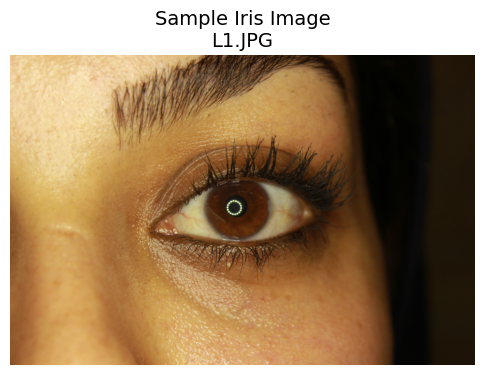

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Path to one sample image (update as needed)
sample_path = '/content/drive/MyDrive/Mini_proj/Dataset/Female/572/L1.JPG'

# Verify and display
if os.path.exists(sample_path):
    img = Image.open(sample_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Sample Iris Image\n{os.path.basename(sample_path)}", fontsize=14)
    plt.axis('off')
    plt.show()
else:
    print(f"❌ Sample image not found: {sample_path}")


#tested how folders and total images


In [ ]:
import os

# Path to the main dataset folder
main_folder = '/content/drive/MyDrive/Mini_proj/Dataset/IrisImage'

# Get all subject subfolders
subfolders = sorted([
    f for f in os.listdir(main_folder)
    if os.path.isdir(os.path.join(main_folder, f))
])

total_images = 0

print("IMAGE COUNTS PER FOLDER:")
print("-" * 40)

# Loop through each subfolder and count images
for idx, folder in enumerate(subfolders, start=1):
    folder_path = os.path.join(main_folder, folder)
    image_files = [
        f for f in os.listdir(folder_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    count = len(image_files)
    total_images += count
    print(f"{idx}. Folder {folder}: {count} images")

print("-" * 40)
print(f"TOTAL FOLDERS: {len(subfolders)}")
print(f"TOTAL IMAGES: {total_images}")


IMAGE COUNTS PER FOLDER:
----------------------------------------
1. Folder 1: 6 images
2. Folder 10: 6 images
3. Folder 100: 6 images
4. Folder 101: 6 images
5. Folder 102: 6 images
6. Folder 103: 6 images
7. Folder 104: 6 images
8. Folder 105: 6 images
9. Folder 106: 6 images
10. Folder 107: 6 images
11. Folder 108: 6 images
12. Folder 109: 6 images
13. Folder 11: 6 images
14. Folder 110: 6 images
15. Folder 111: 6 images
16. Folder 112: 6 images
17. Folder 113: 6 images
18. Folder 114: 6 images
19. Folder 115: 6 images
20. Folder 116: 6 images
21. Folder 117: 6 images
22. Folder 118: 6 images
23. Folder 119: 6 images
24. Folder 12: 6 images
25. Folder 120: 6 images
26. Folder 121: 6 images
27. Folder 122: 6 images
28. Folder 123: 6 images
29. Folder 124: 6 images
30. Folder 125: 6 images
31. Folder 126: 6 images
32. Folder 127: 6 images
33. Folder 128: 6 images
34. Folder 129: 6 images
35. Folder 13: 6 images
36. Folder 130: 6 images
37. Folder 131: 6 images
38. Folder 132: 6 images

In [ ]:
#step 2: split the data into lest and right

In [ ]:
import os
import shutil

# ─── CONFIGURATION ─────────────────────────────────────────────────────────────
base_dir      = '/content/drive/MyDrive/Mini_proj/Dataset'
male_dir      = os.path.join(base_dir, 'Male')
female_dir    = os.path.join(base_dir, 'Female')
# ────────────────────────────────────────────────────────────────────────────────

# Define subfolder names
male_l_dir   = os.path.join(male_dir, 'Male_L')
male_r_dir   = os.path.join(male_dir, 'Male_R')
female_l_dir = os.path.join(female_dir, 'Female_L')
female_r_dir = os.path.join(female_dir, 'Female_R')

# Create subfolders
for d in [male_l_dir, male_r_dir, female_l_dir, female_r_dir]:
    os.makedirs(d, exist_ok=True)

# Helper to split a gender directory
def split_eyes(src_dir, dst_l, dst_r):
    for subj in os.listdir(src_dir):
        subj_path = os.path.join(src_dir, subj)
        if not os.path.isdir(subj_path) or subj in [os.path.basename(dst_l), os.path.basename(dst_r)]:
            continue
        for img in os.listdir(subj_path):
            if not img.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue
            src_img = os.path.join(subj_path, img)
            new_name = f"{subj}_{img}"
            if img.upper().startswith('L'):
                shutil.copy2(src_img, os.path.join(dst_l, new_name))
            elif img.upper().startswith('R'):
                shutil.copy2(src_img, os.path.join(dst_r, new_name))
            else:
                # Optional: handle unexpected names
                pass

# Perform splitting for both genders
split_eyes(male_dir, male_l_dir, male_r_dir)
split_eyes(female_dir, female_l_dir, female_r_dir)

# Verification
male_l_count   = len(os.listdir(male_l_dir))
male_r_count   = len(os.listdir(male_r_dir))
female_l_count = len(os.listdir(female_l_dir))
female_r_count = len(os.listdir(female_r_dir))

print("EYE-SIDE SPLIT COMPLETE:")
print(f"Male Left : {male_l_count} images")
print(f"Male Right: {male_r_count} images")
print(f"Female Left : {female_l_count} images")
print(f"Female Right: {female_r_count} images")


EYE-SIDE SPLIT COMPLETE:
Male Left : 922 images
Male Right: 918 images
Female Left : 1146 images
Female Right: 1146 images


In [ ]:
import os

# Path to main dataset
data_direc = '/content/drive/MyDrive/Mini_proj/Dataset/IrisImage'

# Initialize counts
left_count = 0
right_count = 0
other_count = 0

# Traverse all subject folders
for folder in os.listdir(data_direc):
    folder_path = os.path.join(data_direc, folder)
    if not os.path.isdir(folder_path):
        continue
    for img in os.listdir(folder_path):
        if not img.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        name_upper = img.upper()
        if name_upper.startswith('L'):
            left_count += 1
        elif name_upper.startswith('R'):
            right_count += 1
        else:
            other_count += 1

# Print results
print("IMAGE COUNTS IN ORIGINAL DATASET:")
print(f"Left-eye images : {left_count}")
print(f"Right-eye images: {right_count}")
print(f"Unmatched names : {other_count}")
print(f"Total images    : {left_count + right_count + other_count}")


IMAGE COUNTS IN ORIGINAL DATASET:
Left-eye images : 2071
Right-eye images: 2067
Unmatched names : 84
Total images    : 4222


In [ ]:
import os

# Path to main dataset
data_direc = '/content/drive/MyDrive/Mini_proj/Dataset/IrisImage'

# Initialize counts and lists
left_count = 0
right_count = 0
other_count = 0
unmatched_images = []

# Traverse all subject folders
for folder in os.listdir(data_direc):
    folder_path = os.path.join(data_direc, folder)
    if not os.path.isdir(folder_path):
        continue
    for img in os.listdir(folder_path):
        if not img.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        name_upper = img.upper()
        if name_upper.startswith('L'):
            left_count += 1
        elif name_upper.startswith('R'):
            right_count += 1
        else:
            other_count += 1
            unmatched_images.append(f"{folder}/{img}")

# Print results
print("IMAGE COUNTS IN ORIGINAL DATASET:")
print(f"Left-eye images : {left_count}")
print(f"Right-eye images: {right_count}")
print(f"Unmatched names : {other_count}")
print(f"Total images    : {left_count + right_count + other_count}")

print(f"\nUNMATCHED IMAGE NAMES (first 20):")
for i, img_path in enumerate(unmatched_images[:20]):
    print(f"{i+1}. {img_path}")

if len(unmatched_images) > 20:
    print(f"... and {len(unmatched_images)-20} more")

# Show unique patterns
unique_patterns = set()
for img_path in unmatched_images:
    img_name = img_path.split('/')[-1]
    pattern = img_name[:3] if len(img_name) >= 3 else img_name
    unique_patterns.add(pattern)

print(f"\nUNIQUE PATTERNS IN UNMATCHED NAMES:")
for pattern in sorted(unique_patterns):
    print(f"  {pattern}")


IMAGE COUNTS IN ORIGINAL DATASET:
Left-eye images : 2071
Right-eye images: 2067
Unmatched names : 84
Total images    : 4222

UNMATCHED IMAGE NAMES (first 20):
1. 440/IMG_8025.JPG
2. 440/IMG_8027.JPG
3. 440/IMG_8026.JPG
4. 440/IMG_8030.JPG
5. 440/IMG_8028.JPG
6. 440/IMG_8029.JPG
7. 441/IMG_8034.JPG
8. 441/IMG_8035.JPG
9. 441/IMG_8032.JPG
10. 441/IMG_8031.JPG
11. 441/IMG_8033.JPG
12. 441/IMG_8036.JPG
13. 437/IMG_8012.JPG
14. 437/IMG_8009.JPG
15. 437/IMG_8007.JPG
16. 437/IMG_8008.JPG
17. 437/IMG_8011.JPG
18. 437/IMG_8010.JPG
19. 439/IMG_8019.JPG
20. 439/IMG_8023.JPG
... and 64 more

UNIQUE PATTERNS IN UNMATCHED NAMES:
  IMG


In [ ]:
import os
import pandas as pd

# ─── CONFIG ────────────────────────────────────────────────────────────────────
data_direc     = '/content/drive/MyDrive/Mini_proj/Dataset/IrisImage'
metadata_path  = '/content/drive/MyDrive/Mini_proj/Dataset/METADATA.xlsx'
# ───────────────────────────────────────────────────────────────────────────────

# Step 1: Identify unmatched images in the dataset
unmatched_images = []
for subj in os.listdir(data_direc):
    subj_path = os.path.join(data_direc, subj)
    if not os.path.isdir(subj_path):
        continue
    for img in os.listdir(subj_path):
        if not img.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        if not (img.upper().startswith('L') or img.upper().startswith('R')):
            unmatched_images.append(f"{subj}/{img}")

# Step 2: Load the Excel metadata (assumes a column named 'filename')
df_meta = pd.read_excel(metadata_path)

# If filenames are in the first column without header, fallback:
if 'filename' not in df_meta.columns:
    expected = set(df_meta.iloc[:, 0].astype(str).tolist())
else:
    expected = set(df_meta['filename'].astype(str).tolist())

# Step 3: Compare unmatched_images list vs. metadata filenames
not_in_metadata = [u for u in unmatched_images if u not in expected]
missing_in_dataset = [f for f in expected if f not in unmatched_images]

# Reporting
print(f"Total unmatched images found: {len(unmatched_images)}")
print(f"Of these, {len(not_in_metadata)} are not listed in METADATA.xlsx\n")
print("Examples (first 20) of unmatched images not in metadata:")
for img in not_in_metadata[:20]:
    print(" ", img)

print(f"\nTotal metadata filenames: {len(expected)}")
print(f"Of these, {len(missing_in_dataset)} are not flagged as unmatched images\n")
print("Examples (first 20) of metadata entries not in unmatched list:")
for fn in missing_in_dataset[:20]:
    print(" ", fn)


Total unmatched images found: 84
Of these, 84 are not listed in METADATA.xlsx

Examples (first 20) of unmatched images not in metadata:
  440/IMG_8025.JPG
  440/IMG_8027.JPG
  440/IMG_8026.JPG
  440/IMG_8030.JPG
  440/IMG_8028.JPG
  440/IMG_8029.JPG
  441/IMG_8034.JPG
  441/IMG_8035.JPG
  441/IMG_8032.JPG
  441/IMG_8031.JPG
  441/IMG_8033.JPG
  441/IMG_8036.JPG
  437/IMG_8012.JPG
  437/IMG_8009.JPG
  437/IMG_8007.JPG
  437/IMG_8008.JPG
  437/IMG_8011.JPG
  437/IMG_8010.JPG
  439/IMG_8019.JPG
  439/IMG_8023.JPG

Total metadata filenames: 5
Of these, 5 are not flagged as unmatched images

Examples (first 20) of metadata entries not in unmatched list:
  nan
  F
  sum=
  M
  F 


In [ ]:
#To display the list of unmatched images in ascending order, sort the list before printing:
import os

# Path to main dataset
data_direc = '/content/drive/MyDrive/Mini_proj/Dataset/IrisImage'

# List to hold unmatched image paths
unmatched_images = []

# Traverse all subject folders
for folder in os.listdir(data_direc):
    folder_path = os.path.join(data_direc, folder)
    if not os.path.isdir(folder_path):
        continue
    for img in os.listdir(folder_path):
        if not img.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        name_upper = img.upper()
        if not (name_upper.startswith('L') or name_upper.startswith('R')):
            unmatched_images.append(f"{folder}/{img}")

# Sort the list in ascending order
unmatched_images.sort()

# Print all unmatched image paths
print("List of unmatched images (unnamed by L or R prefix) in ascending order:")
for img_path in unmatched_images:
    print(img_path)

print(f"\nTotal unmatched images: {len(unmatched_images)}")


List of unmatched images (unnamed by L or R prefix) in ascending order:
428/IMG_7946.JPG
428/IMG_7947.JPG
428/IMG_7948.JPG
428/IMG_7949.JPG
428/IMG_7950.JPG
428/IMG_7951.JPG
429/IMG_7959.JPG
429/IMG_7960.JPG
429/IMG_7961.JPG
429/IMG_7962.JPG
429/IMG_7963.JPG
429/IMG_7964.JPG
430/IMG_7965.JPG
430/IMG_7966.JPG
430/IMG_7967.JPG
430/IMG_7968.JPG
430/IMG_7969.JPG
430/IMG_7970.JPG
431/IMG_7971.JPG
431/IMG_7972.JPG
431/IMG_7973.JPG
431/IMG_7974.JPG
431/IMG_7975.JPG
431/IMG_7976.JPG
432/IMG_7977.JPG
432/IMG_7978.JPG
432/IMG_7979.JPG
432/IMG_7980.JPG
432/IMG_7981.JPG
432/IMG_7982.JPG
433/IMG_7983.JPG
433/IMG_7984.JPG
433/IMG_7985.JPG
433/IMG_7986.JPG
433/IMG_7987.JPG
433/IMG_7988.JPG
434/IMG_7989.JPG
434/IMG_7990.JPG
434/IMG_7991.JPG
434/IMG_7992.JPG
434/IMG_7993.JPG
434/IMG_7994.JPG
435/IMG_7995.JPG
435/IMG_7996.JPG
435/IMG_7997.JPG
435/IMG_7998.JPG
435/IMG_7999.JPG
435/IMG_8000.JPG
436/IMG_8001.JPG
436/IMG_8002.JPG
436/IMG_8003.JPG
436/IMG_8004.JPG
436/IMG_8005.JPG
436/IMG_8006.JPG
437/IMG_80

In [ ]:
#Here’s a complete script that processes all unmatched folders with unnamed images like the ones in folder 428, splitting the images so that the first 3 go to the Left folder and the next 3 go to the Right folder:
import os
import shutil

# Base directories for Female (similarly can do for Male)
base_dir   = '/content/drive/MyDrive/Mini_proj/Dataset'
female_dir = os.path.join(base_dir, 'Female')
female_l_dir = os.path.join(female_dir, 'Female_L')
female_r_dir = os.path.join(female_dir, 'Female_R')

# Create L/R subfolders if they don't exist
os.makedirs(female_l_dir, exist_ok=True)
os.makedirs(female_r_dir, exist_ok=True)

# List of unmatched folders you got (folders with unnamed images)
# For example, these are folders like '428', '429', etc.
unmatched_folders = [
    '428', '429', '430', '431', '432', '433', '434', '435', '436', '437', '438', '439', '440', '441'
]

for folder in unmatched_folders:
    folder_path = os.path.join(female_dir, folder)
    if not os.path.exists(folder_path):
        print(f"⚠️ Folder {folder} not found, skipping.")
        continue

    images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    images.sort()

    # Process first 3 to Left, next 3 to Right
    for i, img in enumerate(images[:6]):
        src = os.path.join(folder_path, img)
        if i < 3:
            dst = os.path.join(female_l_dir, f"{folder}_{img}")
        else:
            dst = os.path.join(female_r_dir, f"{folder}_{img}")

        shutil.move(src, dst)
        print(f"Moved {img} from folder {folder} to {'Left' if i < 3 else 'Right'} folder")

print("All unmatched folders have been split into Left and Right subfolders.")


⚠️ Folder 428 not found, skipping.
Moved IMG_7959.JPG from folder 429 to Left folder
Moved IMG_7960.JPG from folder 429 to Left folder
Moved IMG_7961.JPG from folder 429 to Left folder
Moved IMG_7962.JPG from folder 429 to Right folder
Moved IMG_7963.JPG from folder 429 to Right folder
Moved IMG_7964.JPG from folder 429 to Right folder
Moved IMG_7965.JPG from folder 430 to Left folder
Moved IMG_7966.JPG from folder 430 to Left folder
Moved IMG_7967.JPG from folder 430 to Left folder
Moved IMG_7968.JPG from folder 430 to Right folder
Moved IMG_7969.JPG from folder 430 to Right folder
Moved IMG_7970.JPG from folder 430 to Right folder
Moved IMG_7971.JPG from folder 431 to Left folder
Moved IMG_7972.JPG from folder 431 to Left folder
Moved IMG_7973.JPG from folder 431 to Left folder
Moved IMG_7974.JPG from folder 431 to Right folder
Moved IMG_7975.JPG from folder 431 to Right folder
Moved IMG_7976.JPG from folder 431 to Right folder
Moved IMG_7977.JPG from folder 432 to Left folder
Moved 

In [ ]:
#now check total no of images in each folder and total
import os

# Paths
base_dir      = '/content/drive/MyDrive/Mini_proj/Dataset'
male_dir      = os.path.join(base_dir, 'Male')
female_dir    = os.path.join(base_dir, 'Female')
male_l_dir    = os.path.join(male_dir, 'Male_L')
male_r_dir    = os.path.join(male_dir, 'Male_R')
female_l_dir  = os.path.join(female_dir, 'Female_L')
female_r_dir  = os.path.join(female_dir, 'Female_R')

# Count images in each folder
def count_images(folder_path):
    if not os.path.exists(folder_path):
        return 0
    return len([f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

counts = {
    'Male Left': count_images(male_l_dir),
    'Male Right': count_images(male_r_dir),
    'Female Left': count_images(female_l_dir),
    'Female Right': count_images(female_r_dir),
}

total = sum(counts.values())

print("Image counts in each folder:")
for key, value in counts.items():
    print(f"{key}: {value}")

print(f"\nTotal images across all folders: {total}")


Image counts in each folder:
Male Left: 922
Male Right: 918
Female Left: 1173
Female Right: 1173

Total images across all folders: 4186


**Segmentation**

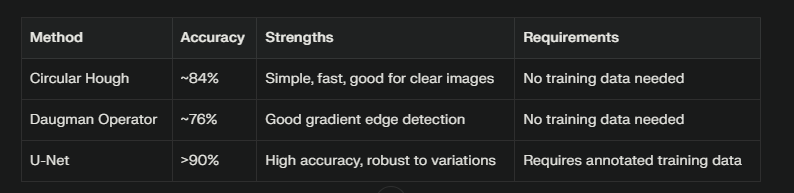

Intially i thought to start with classical methods (Hough Transform) for your initial segmentation pipeline, as it will be fast and easy to implement.

If you later find  dataset contains harder cases (blur, heavy eyelash occlusion, reflections), consider switching to deep learning methods like U-Net or SAM for scalable, robust segmentation.   but based on above table decided to do in unet


->for iris segmentation using U-Net, starting with rough mask generation, annotation guidance, U-Net training, and prediction:


In [ ]:
#Step 1: Rough Mask Generation Using Circular Hough Transform
import cv2
import numpy as np
import os

def generate_rough_mask(image_path, output_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.medianBlur(gray, 5)

    # Detect pupil circle (adjust minRadius and maxRadius as needed)
    circles_pupil = cv2.HoughCircles(
        blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=100,
        param1=50, param2=30, minRadius=20, maxRadius=80
    )
    # Detect iris circle
    circles_iris = cv2.HoughCircles(
        blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=100,
        param1=50, param2=30, minRadius=80, maxRadius=150
    )

    mask = np.zeros_like(gray)
    if circles_pupil is not None and circles_iris is not None:
        pupil = np.round(circles_pupil[0,0]).astype(int)
        iris = np.round(circles_iris[0,0]).astype(int)
        # Fill iris circle white
        cv2.circle(mask, (iris[0], iris[1]), iris[2], 255, thickness=-1)
        # Fill pupil circle black
        cv2.circle(mask, (pupil[0], pupil[1]), pupil[2], 0, thickness=-1)
        cv2.imwrite(output_path, mask)
        print(f"Mask saved: {output_path}")
    else:
        print("Circle detection failed for image:", image_path)

# Example usage:
# generate_rough_mask('path/to/image.jpg', 'path/to/output_mask.jpg')
